In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,Dropout,MaxPooling2D,Dense,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report
import os

In [ ]:
trainpath = 'Datasets/seg_train/seg_train'
testpath = 'Datasets/seg_test/seg_test'
predpath = 'Datasets/seg_pred/seg_pred'

In [3]:
image_size = (227, 227)
batch_size = 64

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  trainpath,
  seed = 123,
  image_size=image_size,
  batch_size=batch_size,
)

Found 14036 files belonging to 6 classes.


In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  testpath,
  seed = 123,
  image_size=image_size,
  batch_size=batch_size,
)

Found 3000 files belonging to 6 classes.


In [6]:
classes_names=train_ds.class_names
print(classes_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


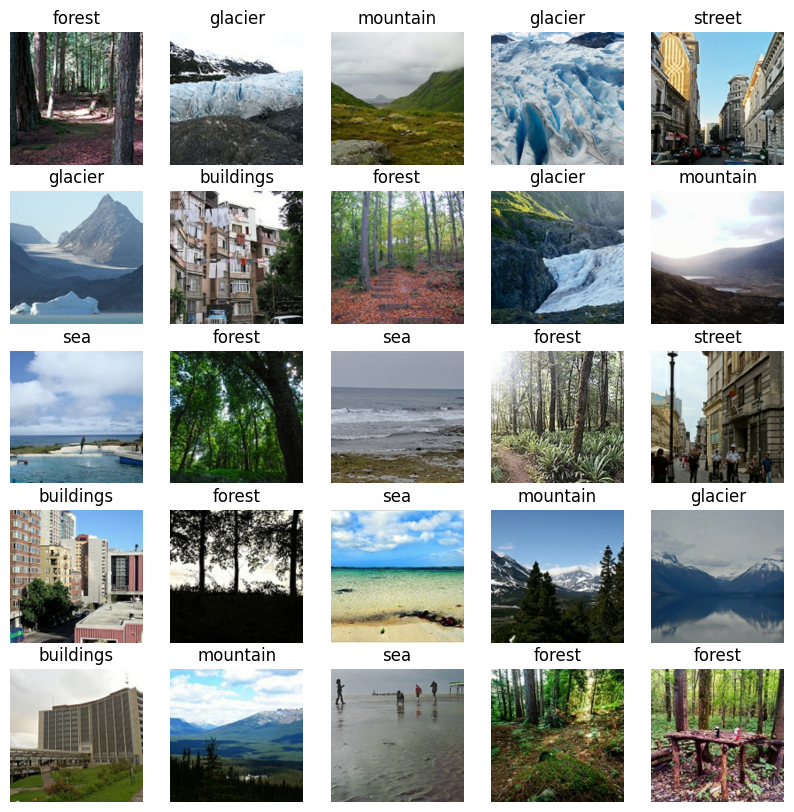

In [7]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes_names[labels[i]])
        plt.axis('off')

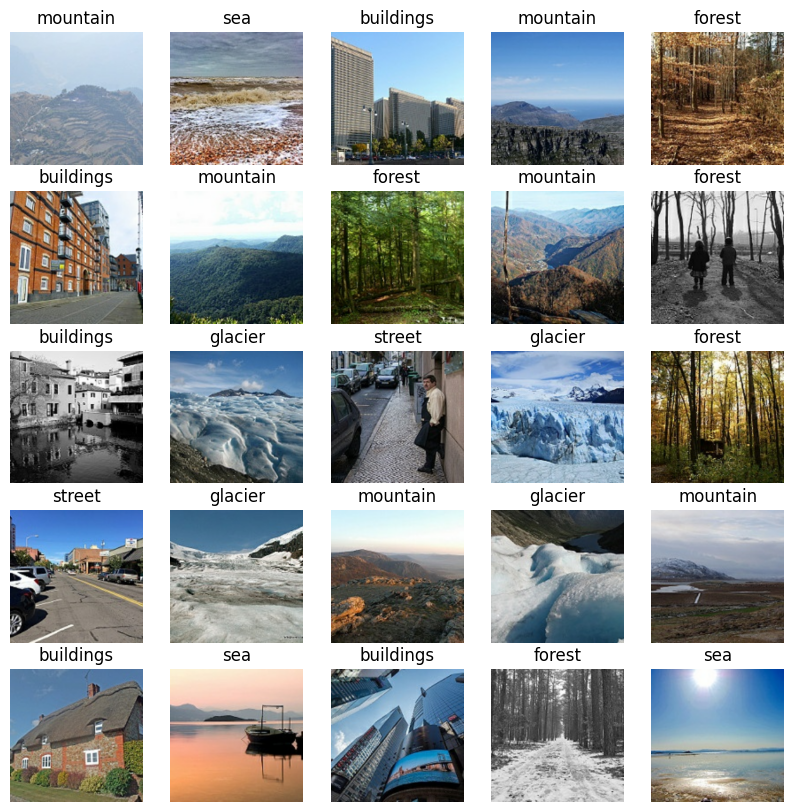

In [8]:
plt.figure(figsize=(10,10))
for image,labels in test_ds.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(classes_names[labels[i]])
        plt.axis('off') 

In [9]:
class_counts = {}
for class_name in os.listdir(trainpath):
    class_dir = os.path.join(trainpath, class_name)  
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))  
        class_counts[class_name] = num_images  
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

buildings: 2191 images
forest: 2271 images
glacier: 2404 images
mountain: 2512 images
sea: 2274 images
street: 2384 images


In [10]:
class_counts = {}
for class_name in os.listdir(testpath):
    class_dir = os.path.join(testpath, class_name)  
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))  
        class_counts[class_name] = num_images  
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

buildings: 437 images
forest: 474 images
glacier: 553 images
mountain: 525 images
sea: 510 images
street: 501 images


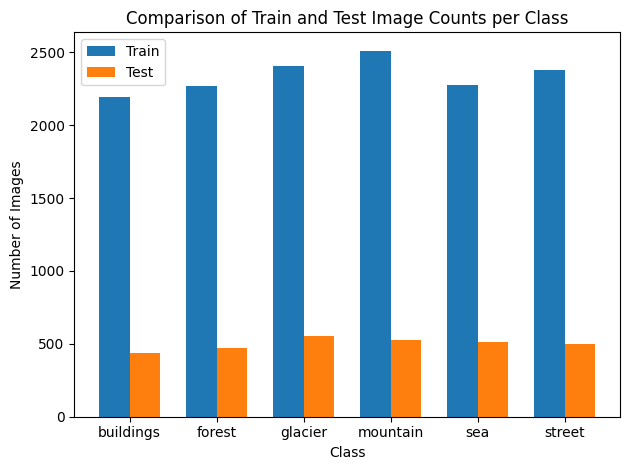

In [11]:
# Class names
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Number of images in each class for train and test
train_counts = [2191, 2271, 2404, 2512, 2274, 2382]
test_counts = [437, 474, 553, 525, 510, 501]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(classes))

# Create bar plot
fig, ax = plt.subplots()
train_bars = ax.bar(index, train_counts, bar_width, label='Train')
test_bars = ax.bar(index + bar_width, test_counts, bar_width, label='Test')

# Add labels, title, and legend
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Comparison of Train and Test Image Counts per Class')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classes)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [12]:
Norm_layer=tf.keras.layers.Rescaling(1/255)
train_ds=train_ds.map(lambda x , y :(Norm_layer(x),y))
test_ds=test_ds.map(lambda x , y :(Norm_layer(x),y))

In [13]:
# AlexNet Model in Sequential Format
model = Sequential()
model.add(Input(shape=(227, 227, 3)))   # AlexNet's input shape

# 1st Convolutional Layer
model.add(Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

# 2nd Convolutional Layer
model.add(Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

# 3rd Convolutional Layer
model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))

# 4th Convolutional Layer
model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))

# 5th Convolutional Layer
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(units=4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=len(classes_names), activation='softmax'))  # Number of classes in the dataset

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │        24,582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,305,926 (222.42 MB)

 Trainable params: 58,305,926 (222.42 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [22]:
history=model.fit(train_ds,validation_data=test_ds,epochs=25,callbacks=[early_stopping])

Epoch 1/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.3776 - loss: 1.4837 - val_accuracy: 0.6187 - val_loss: 0.9753
Epoch 2/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.6433 - loss: 0.8986 - val_accuracy: 0.6783 - val_loss: 0.8483
Epoch 3/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 792s 4s/step - accuracy: 0.7115 - loss: 0.7630 - val_accuracy: 0.7270 - val_loss: 0.7128
Epoch 4/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 532s 2s/step - accuracy: 0.7683 - loss: 0.6303 - val_accuracy: 0.7570 - val_loss: 0.7077
Epoch 5/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.7938 - loss: 0.5695 - val_accuracy: 0.7473 - val_loss: 0.6852
Epoch 6/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.8220 - loss: 0.5143 - val_accuracy: 0.7603 - val_loss: 0.6830
Epoch 7/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.8385 - loss: 0.4524 - val_accuracy: 0.8060 - val_loss: 0.5883
Epoch 8/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.8587 - loss: 0.3916 - val_accu

In [23]:
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.8231 - loss: 0.6423
Test accuracy: 82.60%


In [24]:
loss, accuracy = model.evaluate(train_ds)
print(f'Train accuracy: {accuracy * 100:.2f}%')

220/220 ━━━━━━━━━━━━━━━━━━━━ 91s 412ms/step - accuracy: 0.8937 - loss: 0.3001
Train accuracy: 90.24%


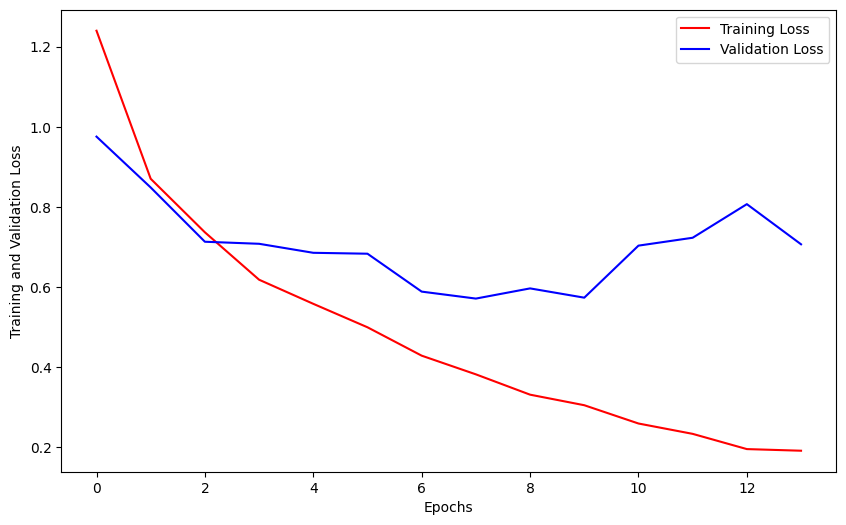

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, c='red', label='Training Loss')
plt.plot(epochs, val_loss, c='blue', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Training and Validation Loss")
plt.legend()
plt.show()

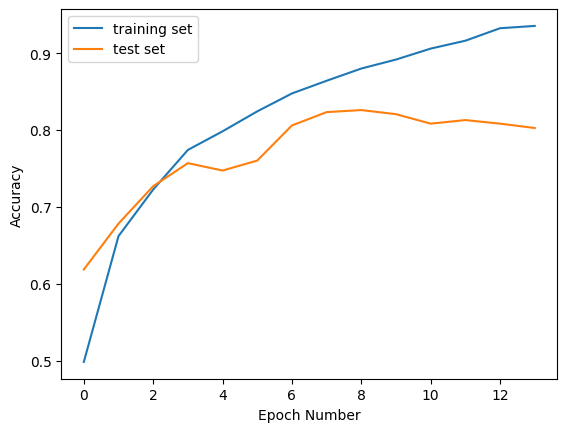

In [26]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

In [27]:
def predictImage(file_name, model):
    img = load_img(file_name, target_size = (227,227))
    img_array = img_to_array(img)
    img_pro = np.expand_dims(img_array, axis=0)
    img_pro/=255
    img_pred = model.predict(img_pro)
    index = np.argmax(img_pred)


    plt.title("Prediction - {}".format(str(classes_names[index]).title()), size=18, color='red')
    plt.imshow(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


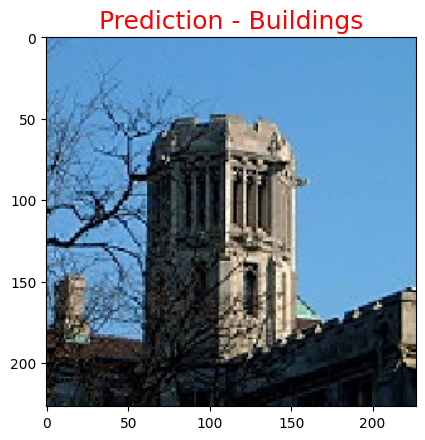

In [29]:
predictImage('seg_pred/seg_pred/242.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


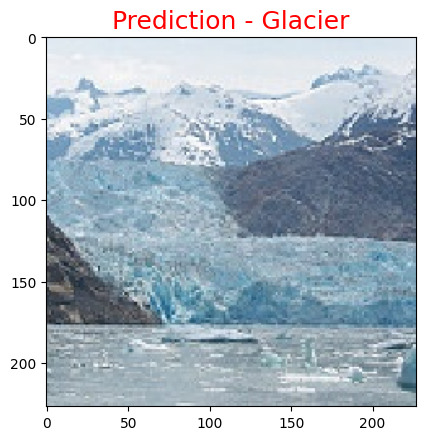

In [30]:
predictImage('seg_pred/seg_pred/101.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


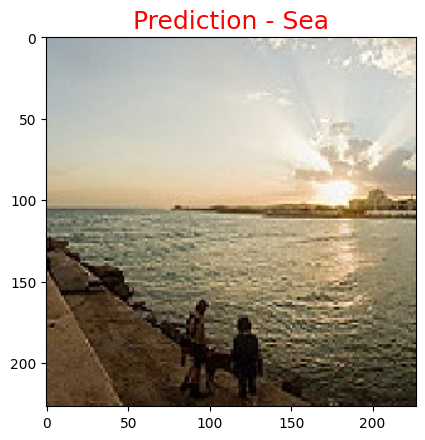

In [32]:
predictImage('seg_pred/seg_pred/274.jpg', model)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

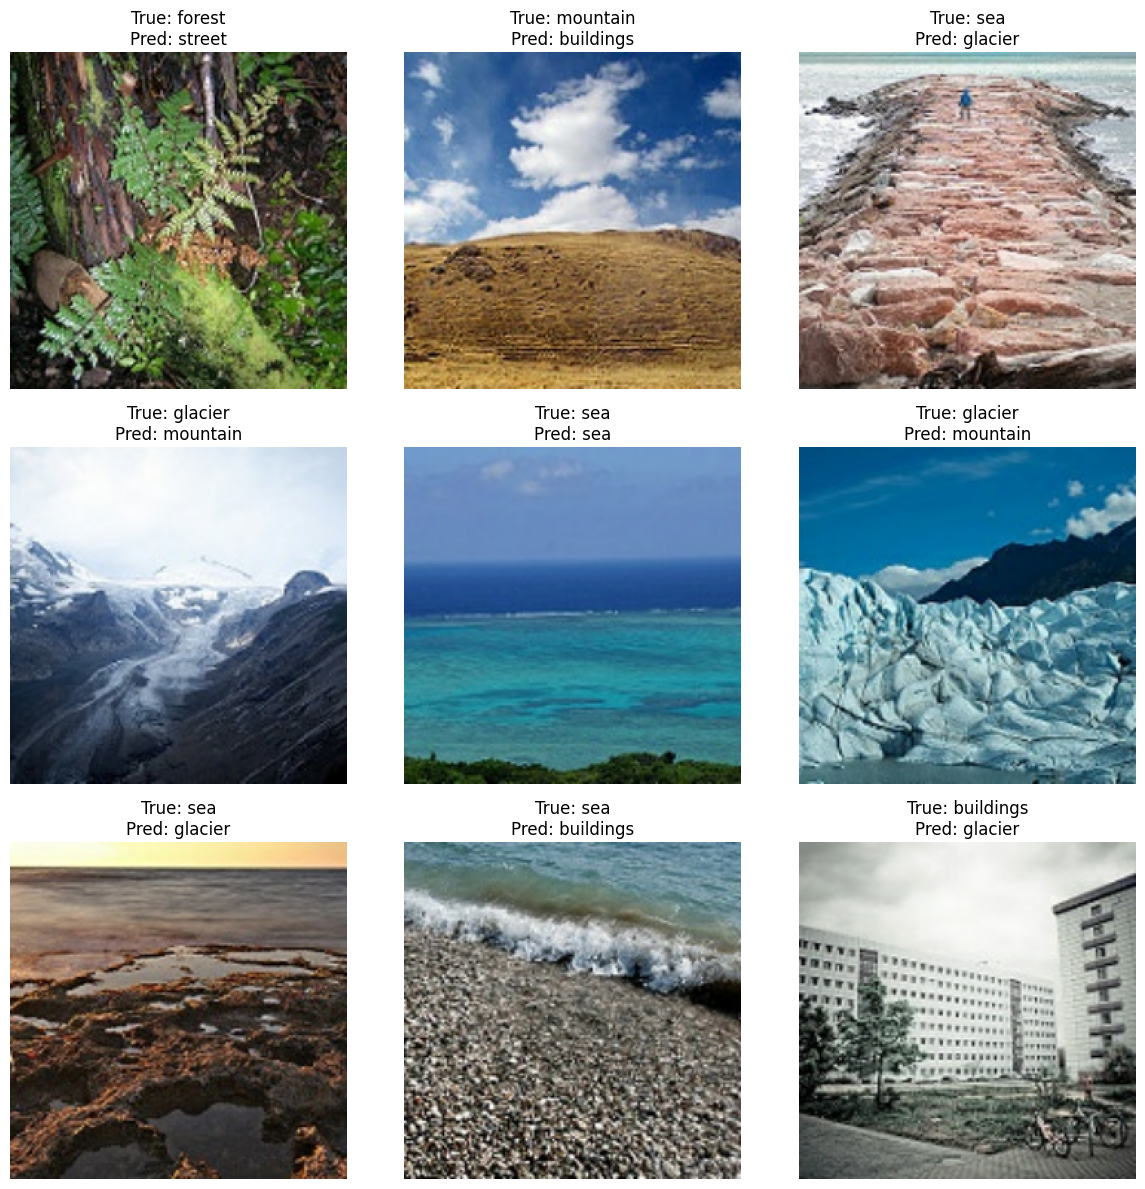

In [33]:
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

report = classification_report(y_true, y_pred, target_names=classes_names)  
print(report)

misclassified_indices = np.where(y_true != y_pred)[0]

misclassified_images = []
misclassified_labels = []
misclassified_preds = []

for i, (images, labels) in enumerate(test_ds):
    if i * batch_size >= len(y_true): 
        break
    for j in range(len(images)):
        if len(misclassified_indices) == 0:
            break
        if (i * batch_size + j) in misclassified_indices:
            misclassified_images.append(images[j].numpy())  
            misclassified_labels.append(classes_names[labels[j]])  
            misclassified_preds.append(classes_names[y_pred[i * batch_size + j]]) 


plt.figure(figsize=(12, 12))
for i in range(min(9, len(misclassified_images))):  
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((misclassified_images[i] * 255).astype("uint8"))  
    plt.title(f"True: {misclassified_labels[i]}\nPred: {misclassified_preds[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()